<a href="https://colab.research.google.com/github/yimuzy/Is20f/blob/master/xuan/FFT_FOR_HESTON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy import *
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so

In [ ]:
class Heston:

    def __init__(self, S0, v0, r, kappa, theta, xi, rho):
        self.S0 = S0
        self.v0 = v0
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho

    def F_function(self, T , status, lambda_, phi):
        kappa = self.kappa
        theta = self.theta
        xi = self.xi
        rho = self.rho
        v0 = self.v0
        r = self.r
        s0 = self.S0
        if status == 1:
            u = 0.5
            b = kappa - rho * xi + lambda_
        else:
            u = -0.5
            b = kappa + lambda_
        a = kappa * theta
        x = log(s0)
        d = sqrt((rho * xi * phi * 1j - b)**2 - xi**2 * (2 * u * phi * 1j - phi**2))
        g = (b - rho * xi * phi * 1j + d) / (b - rho * xi * phi * 1j - d)
        C = r * phi * 1j * T + (a / xi**2)*((b - rho * xi * phi * 1j + d) * T - 2 * log((1 - g * exp(d * T))/(1 - g)))
        D = (b - rho * xi * phi * 1j + d) / xi**2 * ((1 - exp(d * T)) / (1 - g * exp(d * T)))
        return exp(C + D * v0 + 1j * phi * x)
        

    def P_function(self, T , status, lambda_, K):
        kappa = self.kappa
        theta = self.theta
        xi = self.xi
        rho = self.rho
        v0 = self.v0
        r = self.r
        s0 = self.S0
        integ = lambda phi: (exp(-1j * phi * log(K)) * self.F_function(T , status, lambda_, phi) / (1j * phi)).real
        return (0.5 + (1 / pi) * quad(integ, 0, 150)[0])

    def Call_price(self, T, K, lambda_):
        kappa = self.kappa
        theta = self.theta
        xi = self.xi
        rho = self.rho
        v0 = self.v0
        r = self.r
        s0 = self.S0
        p1 = self.P_function(T,1,lambda_,K)
        p2 = self.P_function(T,2,lambda_,K)
        return (s0 * p1 - K * exp(-r * T) * p2)

    def SimpsonW(self, N,eta):
        delt = np.zeros(N, dtype=np.float)
        delt[0] = 1
        j = np.arange(1, N + 1, 1)
        SimpsonW = eta*(3 + (-1) ** j - delt) / 3
        return SimpsonW

    def error_function(self, alpha):
        kappa = self.kappa
        theta = self.theta
        xi = self.xi
        rho = self.rho
        v0 = self.v0
        r = self.r
        T = 10
        k = np.log(80)
        lambda_ = 0
        error = 0
        N =2**10
        eta = 150/N
        v = np.asarray([i*eta for i in range(N)])
        Psi = np.asarray([self.F_function(T , 2, lambda_, (vj-(alpha+1)*1j))  for vj in v])
        ps =  (np.exp(1j*(-k)*v) * np.exp(-r*T) * Psi/(alpha + alpha**2 - v**2 + 1j*v*(2*alpha+1))).real
        for i in range(len(ps)):
          error += (np.log(ps[i]) - alpha*k)**2
        return error

    def Hestonfft(self, T,K,lambda_):
        kappa = self.kappa
        theta = self.theta
        xi = self.xi
        rho = self.rho
        v0 = self.v0
        r = self.r
        s0 = self.S0
        k = np.log(K)
        x0 = np.log(s0)   
        N =2**10
        alpha = 1.5
        eta = 150/N
        lambda1 = 2 * np.pi / (N *eta)
        beta= x0 - lambda1*N/2
        b = 0.5 * N * lambda1
        km = np.asarray([beta+i*lambda1 for i in range(N)])
        W = self.SimpsonW(N,eta)
        v = np.asarray([i*eta for i in range(N)])
        Psi = np.asarray([self.F_function(T , 2, lambda_, (vj-(alpha+1)*1j))  for vj in v])
        FFTFunc = W * np.exp(1j*(b-x0)*v) * np.exp(-r*T) * Psi/(alpha + alpha**2 - v**2 + 1j*v*(2*alpha+1))

        y = np.fft.fft(FFTFunc).real
        cT = eta * np.exp(-alpha * km) * y/np.pi

        ymin = (xi - 2*k*rho - np.sqrt(xi**2+4*k**2-4*k*rho*xi))/(2*xi*(1-rho**2))
        ymax = (xi - 2*k*rho - np.sqrt(xi**2+4*k**2-4*k*rho*xi))/(2*xi*(1-rho**2))
        
        #alpha1 = so.fmin(self.error_function, alpha, disp = 0)[0]

        return np.exp(km),cT#,alpha1


In [ ]:
H = Heston(100, 0.0175, 0., 1.5768, 0.0398, 0.5751, -0.5751)
H.Call_price(10, 80, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.log is deprecated and will be remove

10.817302243596643

In [ ]:
Km,b=H.Hestonfft(10,80,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.exp is deprecated and will be remove

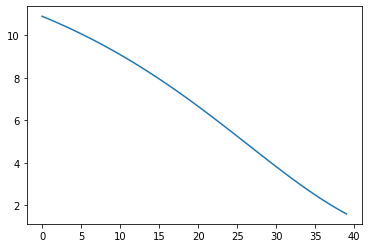

In [ ]:

plt.plot(b[480:520])

In [ ]:
AS = np.array([H.Call_price(10, K, 0) for K in Km[480:520]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.log is deprecated and will be remove

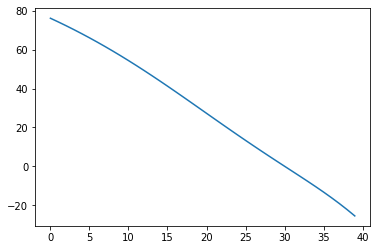

In [ ]:
plt.plot(AS)

In [10]:
class Heston:
    def __init__(self, S0, v0, r, kappa, theta, xi, rho):
        self.S0 = S0
        self.v0 = v0
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho
        
    #char func for ln(S_T) from Ng05
    def charfun(self, T, u):
        t1 = self.kappa - self.rho*self.xi*1j*u
        D = np.sqrt(t1**2+(u**2+1j*u)*self.xi**2)
        G = (t1-D)/(t1+D)
        t2 = 1-G*np.exp(-D*T)
        f1 = np.exp(1j*u*(np.log(self.S0+self.r*T)))
        f2 = np.exp(self.v0*(1-np.exp(-D*T))*(t1-D)/self.xi**2/t2)
        f3 = np.exp(self.kappa*self.theta*(
            T*(t1-D)-2*np.log(t2/(1-G)))/self.xi**2)
        return f1*f2*f3

    def psi(self, w, T, alpha):
        r = self.r
        o1 = np.exp(-r*T)
        o1 = o1*self.charfun(T, w - (alpha+1)*1j)
        o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
        return o1/o2
    
    #carr-madan method with damping
    def price_cm(self, K, T, alpha = 1.5):
        k = np.log(K)
        integrand = lambda w: (np.exp(-1j*w*k)*self.psi(w, T, alpha)).real
        integral = quad(integrand, 0, np.inf)[0]
        return np.exp(-alpha*k)/np.pi*integral

    def SimpsonW(self, N,eta):
        delt = np.zeros(N, dtype=np.float)
        delt[0] = 1
        j = np.arange(1, N + 1, 1)
        SimpsonW = eta*(3 + (-1) ** j - delt) / 3
        return SimpsonW

    def Hestonfft(self, T,K):
        kappa = self.kappa
        theta = self.theta
        xi = self.xi
        rho = self.rho
        v0 = self.v0
        r = self.r
        s0 = self.S0
        k = np.log(K)
        x0 = np.log(s0)   
        N =2**10
        alpha = 1.5
        eta = 0.15
        lambda1 = 2 * np.pi / (N *eta)
        beta= x0 - lambda1*N/2
        km = np.asarray([beta+i*lambda1 for i in range(N)])
        W = self.SimpsonW(N,eta)
        v = np.asarray([i*eta for i in range(N)])
        Psi = np.asarray([self.psi(vj, T, alpha)  for vj in v])
        FFTFunc = Psi*np.exp(-1j*beta*v)*W

        y=np.fft.fft(FFTFunc).real
        cT=np.exp(-alpha*km)*y/np.pi

        return np.exp(km),cT

In [11]:
H = Heston(100, 0.0175, 0., 1.5768, 0.0398, 0.5751, -0.5751)
H.price_cm(80, 10, alpha = 1.5)

32.57957785990925

In [12]:
k,c= H.Hestonfft(10,80)
print(np.interp(80,k,c))

32.58952680972135


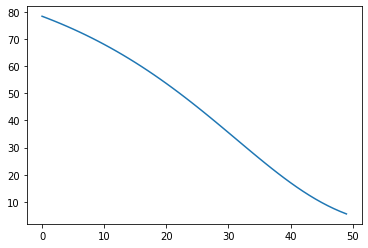

In [18]:
plt.plot(c[475:525])

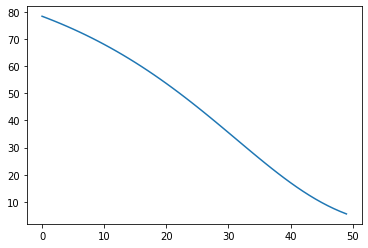

In [19]:
AS = np.array([H.price_cm(K,10, alpha = 1.5) for K in k[475:525]])
plt.plot(AS)

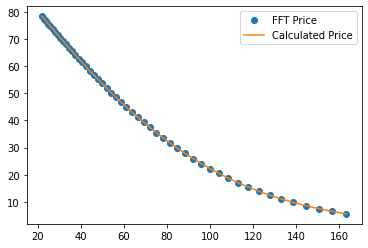

In [25]:
plt.plot(k[475:525],AS,'o',label='FFT Price')
plt.plot(k[475:525],c[475:525],label='Calculated Price')
plt.legend()